# Lab 5: Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
To understand the importance of a complex loss function.
To see how I can optimize not only over network parameters,
but over other objects (such as images) as well.

For this lab, I implement the style transfer algorithm of Gatys et al.

* Extract statistics from the content and style images
* Formulate an optimization problem over an input image
* Optimize the image to match both style and content

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [ ]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving lab5image.jpg to lab5image.jpg

Upload Style Image


Saving lab5styleimageres.jpg to lab5styleimageres.jpg
Content Path: <_io.BytesIO object at 0x7fde759f8450>
Style Path: <_io.BytesIO object at 0x7fde75c10ae0>


In [ ]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


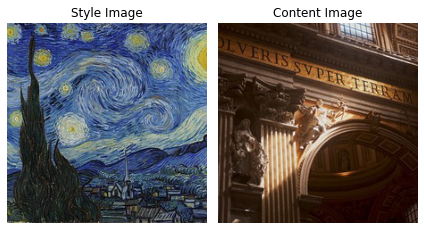

In [ ]:
# Display the images
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    plt.axis('off')
    if title is not None:
        plt.title(title)

plt.subplot(1,2,1)
plt.axis('off')
display(style_image, title='Style Image')

plt.subplot(1,2,2)
plt.axis('off')
display(content_image, title='Content Image')

plt.tight_layout()
plt.show()

___

### Part 1
Create a class to extract the layers needed for statistics

* Use the pretrained VGG in my model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image


In [ ]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = mean.view(-1, 1, 1)
      self.std = std.view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [ ]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2",
             "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3",
             "maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4",
             "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer.
ccl1 = vgg_names.index('conv1_2')
chosen_content_layer = [ccl1]
csl1, csl2, csl3, csl4 = vgg_names.index('conv2_1'), vgg_names.index('conv3_1'), vgg_names.index('conv4_1'), vgg_names.index('conv5_1')
chosen_style_layer = [csl1, csl2, csl3, csl4]

# Initialize our models (only once to hopefully avoid the problem of computing backprop twice).
content_model = VGGIntermediate(requested=chosen_content_layer).cuda()
style_model = VGGIntermediate(requested=chosen_style_layer).cuda()

# This returns dictionaries {layer number (corresponding with the index I wanted): weights associated (after putting my image in)}
content_layers = content_model(content_image)
style_layers = style_model(style_image)

# This gets only the weights associated in a list that correspond with the images I want to mess with.
content_layers = [content_layers[i] for i in content_layers]
#[content_layers.values()]
style_layers = [style_layers[i] for i in style_layers]
#[style_layers.values()]


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

___

### Part 2
Create a classes for the style and content loss

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class

In [ ]:
def gram_matrix(input):
   # input size = batch, channel, height, width.
   b, c, h, w = input.size() 
   x = input.view(b*c, h*w)
   gram = torch.mm(x, x.t())
   return gram.div(b*c*h*w)

# Computes the MSELoss between the content image and the generated image.
class ContentLoss(nn.Module):
  def __init__(self, cont_image):
    super(ContentLoss, self).__init__()
    # Detach from the pre-trained network
    self.targ_image = cont_image.clone().detach()

  def forward(self, input_image):  
    # Compute the MSE of the generated image vs. my content image.
    return F.mse_loss(input_image, self.targ_image)

class StyleLoss(nn.Module):
  def __init__(self, style_image):
    super(StyleLoss, self).__init__()
    # Detach from the pre-trained network
    self.gram_style = gram_matrix(style_image.clone().detach())
  
  def forward(self, input_image): 
    # Put input_image through the gram matrix
    gram = gram_matrix(input_image)

    # Compute the MSE of the gram style image vs. my gram generated image.
    return F.mse_loss(gram, self.gram_style)

___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

* Use an Adam optimizer
* Show both the content and the style loss every 50 steps


In [ ]:
# Copy the content image to use for the model
copy_content_image = content_image.clone().requires_grad_(True)

# Declare epochs, etc.
num_epochs = 500
alpha = 2.5
beta = 2500000

# Declare optimizer and 
optimizer = optim.Adam([copy_content_image], lr=0.1)
model = VGGIntermediate(requested=chosen_content_layer + chosen_style_layer).cuda()

content_losses = [ContentLoss(l) for l in content_layers]  # This creates a ContentLoss function for each layer.
                                                           # (I only use one layer, so there is only one function in this list.)
style_losses = [StyleLoss(l) for l in style_layers]        # This creates a StyleLoss function for each layer.
                                                           # (I use four layers, so there are four functions in this list.)
image_list = []
for epoch in range(num_epochs):
  optimizer.zero_grad()

  my_model = model(copy_content_image)
  total_content_loss = 0
  total_style_loss = 0

  # The first for loop
    # Remember that content_losses is a list of functions. So, need to index the list which is why we have 'content_losses[i].'
    # Since content_losses[i] is a function, we need to pass in something for that function to do. 'my_model' is the model, so we need to
    # pass something into that. We want to pass the selected pre-trained layers from vgg into the model so we can get the alterations to our
    # picture. So, my_model[chosen_content_layer[i]] gives us the new weights and whatnot for the content image and the pre-trained layers.
    # Passing my_model[chosen_content_layer[i]] into content_losses[i] will send the new weights from my_model[chosen_content_layer[i]] to
    # the ContentLoss function. This will compute the MSE between the original content image, and the new content image that has the
    # pre-trained layers applied to it. We then add this value (the MSE) to total_content_loss so we can get the total content loss across
    # all layers. Since I only use one content layer, this only happens one time.
  # The second for loop
    # This is loop is the exact same as the previous for loop, just with the style layers and image instead of content layers and image.

  for i in range(len(content_losses)):
    total_content_loss += content_losses[i](my_model[chosen_content_layer[i]])
  for i in range(len(style_losses)):
    total_style_loss += style_losses[i](my_model[chosen_style_layer[i]])
  
  total_content_loss *= alpha
  total_style_loss   *= beta

  total_loss = total_content_loss + total_style_loss

  total_loss.backward()
  optimizer.step()

  if epoch % 50 == 0:
    print(f"Epoch: {epoch}, content_loss: {total_content_loss}, style_loss: {total_style_loss}")
print("Done!")

Epoch: 0, content_loss: 0.0, style_loss: 151464.8125
Epoch: 50, content_loss: 31.086467742919922, style_loss: 2207.943115234375
Epoch: 100, content_loss: 30.847070693969727, style_loss: 779.3544311523438
Epoch: 150, content_loss: 31.431758880615234, style_loss: 3651.63671875
Epoch: 200, content_loss: 37.448917388916016, style_loss: 66957.6640625
Epoch: 250, content_loss: 35.408958435058594, style_loss: 10775.134765625
Epoch: 300, content_loss: 32.24941635131836, style_loss: 663.0426025390625
Epoch: 350, content_loss: 31.92957878112793, style_loss: 348.6053161621094
Epoch: 400, content_loss: 31.87782096862793, style_loss: 252.74143981933594
Epoch: 450, content_loss: 31.810699462890625, style_loss: 313.3307800292969
Done!


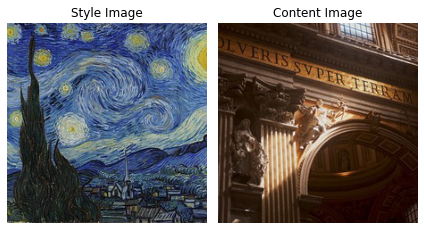

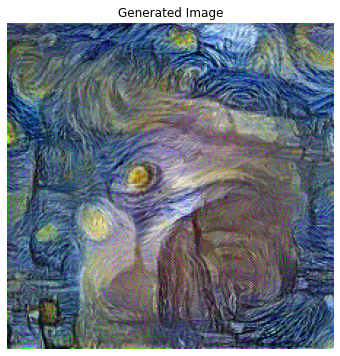

In [ ]:
# Print original images
plt.subplot(1,2,1)
display(style_image, title='Style Image')

plt.subplot(1,2,2)
display(content_image, title='Content Image')

plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
display(torch.clamp(copy_content_image, min=0, max=1), title="Generated Image")

Describe equations 1,3,4,5 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

**Equation 1: $L_{content}(\overrightarrow{p}, \overrightarrow{x},l) = \frac{1}{2} \sum_{i,j}(F_{ij}^{l}-P_{ij}^{l})^2$**

$L_{content}(\overrightarrow{p}, \overrightarrow{x},l)$ : 

- This is how the paper calculates content loss, where $\overrightarrow{p}$ is the content image, $\overrightarrow{x}$ is is the generated image, and $\overrightarrow{l}$ is the layer that we are computing the loss for.

$F_{ij}^{l}$ : 

- After each layer $l$ is passed through the pre-trained VGG network, $F_{ij}^{l}$ becomes a list of all the activation maps for the generated image, where $i$ represents the numbers of filters from layer $l$ on pixel $j$.

$P_{ij}^{l}$ : 

- After each layer $l$ are passed through the pre-trained VGG network, $P_{ij}^{l}$ becomes a list of all the activation maps for the content image, where $i$ and $j* are the same definition as above.

$\frac{1}{2} \sum_{i,j}(F_{ij}^{l}-P_{ij}^{l})^2$ :

- This finds the mean squared error between the generated image and the content layers, sums them up, and divides by 2

<hr>

**Equation 3: $G_{ij}^{l} = \sum_{k}F_{ik}^{l}F_{jk}^{l}$**

$G_{ij}^{l}$ : 

- This is the gram matrix, or the inner product on layer $l$ between the feature maps $i$ and $j$ (in vector form). $F_{ij}$ and $F_{jk}$ are parallel to $F_{ij}$ from the above equation. The gram matrix tells us how similar all of the activation maps are.

<hr>

**Equation 4: $E_{l} = \frac{1}{4N_{l}^{2}M_{l}^{2}} \sum_{i,j}(G_{ij}^{l}-A_{ij}^{l})^{2}$** :

$E_{l}$ : 

- This is the contribution to the total loss from a single layer $l$.

$N_{l}$ : 

- For each layer $l$, $N_{l}$ is the number of channels for each feature map in that layer.

$M_{l}$ : 

- For each later $l$, $M_{l}$ is the height $*$ width for each feature map in that layer. 

$G_{ij}^{l}$ : 

- This is the gram matrix for each layer $l$ of the generated image.

$A_{ij}^{l}$ : 

- This is the gram matrix for each layer $l$ of the style image.

<hr>

**Equation 5: $L_{style}(\overrightarrow{a}, \overrightarrow{x}) = \sum_{l=0}^{L}w_{l}E_{l}$**

$L_{style}(\overrightarrow{a},\overrightarrow{x})$ : 

- This equation computes the loss of the style between the style image $\overrightarrow{a}$ and the generated image $\overrightarrow{x}$.

$w_{l}$ : 

- This represents the weight factor of contribution of each layer.

$E_{l}$ : 

- This is the value from equation 4. 